
# Dependencies

In [2]:
%pip install transformers
%pip install huggingface_hub
%pip install --upgrade tensorflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install accelerate
%pip install -i https://pypi.org/simple/ bitsandbytes

Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple/
Note: you may need to restart the kernel to use updated packages.


# Connect to HuggingFace

In [4]:
from huggingface_hub import notebook_login
notebook_login()

# Load the model

In [5]:
import torch
import accelerate
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration, BitsAndBytesConfig

model_id = "google/paligemma-3b-mix-448"

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=False,
    load_in_8bit=False,
)

model = PaliGemmaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map={"":0}
)

# Print the size in GB of the model
print(f"Model size: {sum(t.numel() for t in model.parameters()) / 1e9:.2f} GB")

processor = AutoProcessor.from_pretrained(model_id)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2024-05-31 14:53:43.505373: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-31 14:53:44.846958: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Model size: 1.73 GB


# Run the model

## Load the image

In [6]:
import os
import requests
from PIL import Image

prompt = "Read me all the text on this image"

img_path = "../../images/Temp"
img_list = os.listdir(img_path)
raw_images = [Image.open(f"{img_path}/{img}") for img in img_list]

# Remove the transparency channel
raw_images = [img.convert("RGB") for img in raw_images]

## Predict the answer

In [7]:
max_output_length = 300

responses = []
for i, raw_image in enumerate(raw_images):
  inputs = processor(prompt, raw_image, return_tensors="pt")
  output = model.generate(**inputs, max_new_tokens=max_output_length)
  output = processor.decode(output[0], skip_special_tokens=True)[len(prompt):]
  responses.append(output)

print(f"Prediction done for {len(responses)} images.")

You're using a GemmaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


/home/wfd/miniconda3/envs/York/lib/python3.12/site-packages/transformers/generation/utils.py:1637: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
/home/wfd/miniconda3/envs/York/lib/python3.12/site-packages/bitsandbytes/nn/modules.py:426: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(
/home/wfd/miniconda3/envs/York/lib/python3.12/site-packages/transformers/generation/utils.py:1637: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `i

Prediction done for 12 images.


## Check if the model is able to detect something on screenshots

In [8]:
%pip install opencv-python

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [9]:
import cv2
import re
import matplotlib.pyplot as plt
import numpy as np

def add_text_to_image(image, text):
    # Convert the PIL image to a numpy array
    image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Format the output by matching a regex
    formatted_output = re.findall(r'loc[0-9]{4}', text)
    formatted_output = [int(x.replace('loc', '')) for x in formatted_output]

    if (len(formatted_output) > 4):
        formatted_output = [x for x in formatted_output if x != 0]

    # Coordinates of the bounding box
    y_min, x_min, y_max, x_max = formatted_output[:4]

    # Check if the image was loaded successfully
    if image is None:
        print("Error: Could not load image.")
    else:
        height, width, _ = image.shape

        # Convert values to coordinates
        x_min = int((x_min / 1024) * width)
        y_min = int((y_min / 1024) * height)
        x_max = int((x_max / 1024) * width)
        y_max = int((y_max / 1024) * height)

        # Draw the rectangle on the image
        color = (0, 0, 255)  # Color of the rectangle (Green in BGR format)
        thickness = 2  # Thickness of the rectangle border
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), color, thickness)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

This prompt should be generated by another LLM that understands the question, the content of the image and asks PaliGemma to detect something to create a box.

/home/wfd/miniconda3/envs/York/lib/python3.12/site-packages/transformers/generation/utils.py:1637: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(



<loc0136><loc0937><loc0203><loc0949><loc1022> top right dots


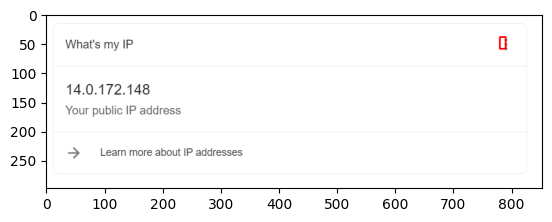

In [10]:
prompt = "detect top right dots"
max_output_length = 300

img_index = 3
raw_image = raw_images[img_index]

inputs = processor(prompt, raw_image, return_tensors="pt")
output = model.generate(**inputs, max_new_tokens=max_output_length)
output = processor.decode(output[0], skip_special_tokens=True)[len(prompt):]

print(f"{output}")

add_text_to_image(raw_image, output);


<loc0579><loc0084><loc0697><loc0127> pencil icon ; <loc0860><loc0705><loc0966><loc0761> pencil icon ; <loc0412><loc0084><loc0515><loc0137> pencil icon


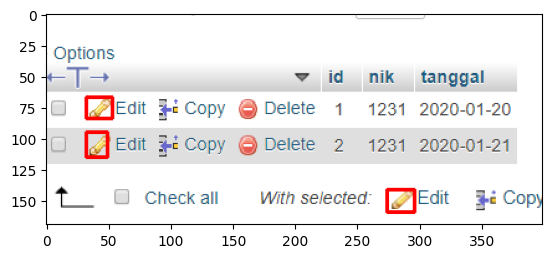

In [11]:
prompt = f"detect pencil icon"

img_index = 6
raw_image = raw_images[img_index]

inputs = processor(prompt, raw_image, return_tensors="pt")
output = model.generate(**inputs, max_new_tokens=max_output_length)
output = processor.decode(output[0], skip_special_tokens=True)[len(prompt):]

print(f"{output}")

if (output.strip() != ""):
  for out in output.split(";"):
    raw_image = add_text_to_image(raw_image, out)


<loc0078><loc0531><loc0170><loc0604> search icon


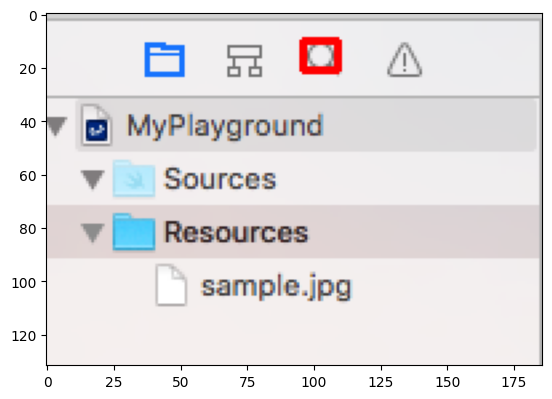

In [29]:
prompt = f"detect search icon"

raw_image_url = "./section_0.png"
raw_image = Image.open(raw_image_url)

inputs = processor(prompt, raw_image, return_tensors="pt")
output = model.generate(**inputs, max_new_tokens=max_output_length)
output = processor.decode(output[0], skip_special_tokens=True)[len(prompt):]

print(f"{output}")

if (output.strip() != ""):
  for out in output.split(";"):
    raw_image = add_text_to_image(raw_image, out)